# DreaMS molecular networking

## Introduction

DreaMS embeddings can be naturally used for molecular networking. Once the embeddings are computed, their similarity can be used to connect spectra into a k-nearest neighbor (k-NN) graph forming a molecular network. Our [paper](https://chemrxiv.org/engage/chemrxiv/article-details/6626775021291e5d1d61967f) demonstrates that DreaMS spectral similarity outperforms prior methods (e.g., modified cosine similarity, spectral entropy, MS2DeepScore) in terms of the following metrics:

1. Correlation to chemical similarity of underlying compounds.

2. Library matching performance (i.e., retrieval of different spectra of the same compound).

3. Analog search performance (i.e., retrieval of spectra of distinct but structurally similar compounds).

4. Robustness to low-quality spectra.

Unlike traditional spectral similarity methods that primarily rely on direct matching of peaks and their intensities, DreaMS similarity is derived from a neural network-based approach. As a result, DreaMS often finds connections between spectra that may not be directly related according to conventional metrics, but are likely to represent structurally similar molecules. This ability to detect additional relationships makes DreaMS particularly powerful for molecular networking applications. Before proceeding to the construction of the molecular network, we will look at the few examples of such spectra.

Import necessary libraries

In [38]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from pathlib import Path
import dreams.utils.spectra as su
import dreams.utils.data as du
from dreams.api import dreams_embeddings
from dreams.definitions import *

Load example dataset downloaded from [MSV000086206](https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=11fbd0d4c9144a6c813b196d865567ab).

In [42]:
in_pth = Path('../data/S_N1.mzML')
msdata = du.MSData.load(in_pth)
embs = dreams_embeddings(msdata)
embs.shape

(3809, 1024)

Identify pairs of spectra with high DreaMS similarity but low modified cosine similarity, which are typically not connected in a standard molecular networking.

1137 1165
DreaMS similarity: 0.9109248
Modified cosine similarity: 0.5023494505951352


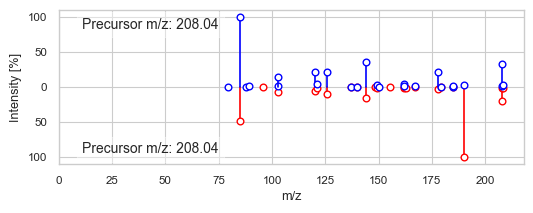

2358 2840
DreaMS similarity: 0.8620262
Modified cosine similarity: 0.6811504415010509


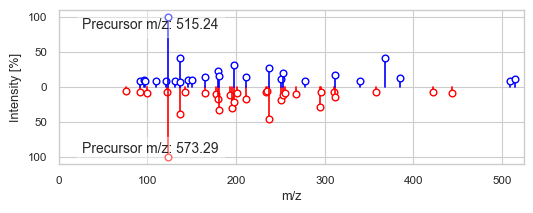

1484 1979
DreaMS similarity: 0.88867676
Modified cosine similarity: 0.6725187688330744


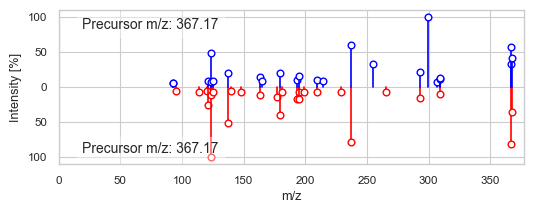

2375 2584
DreaMS similarity: 0.9429935
Modified cosine similarity: 0.549318478822847


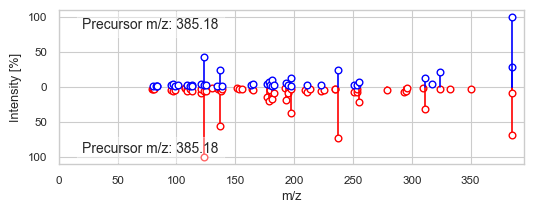

2691 2797
DreaMS similarity: 0.9129119
Modified cosine similarity: 0.6463478109508536


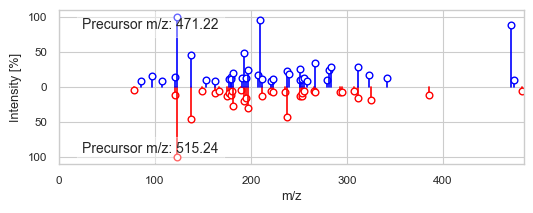

2330 2445
DreaMS similarity: 0.9423888
Modified cosine similarity: 0.6216880411880263


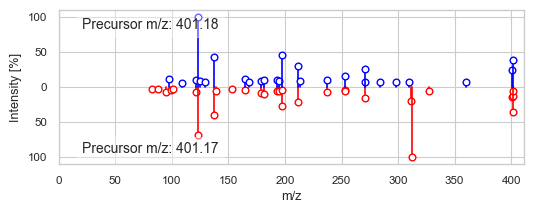

1631 3082
DreaMS similarity: 0.87816286
Modified cosine similarity: 0.6838237576062526


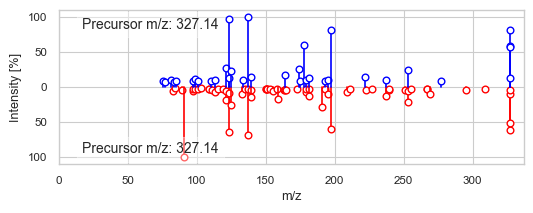

In [24]:
# Find all pairs with DreaMS similarity > 0.85
sims = cosine_similarity(embs)
x, y = np.where(sims > 0.85)

# Define modified cosine similarity function
cos_sim = su.PeakListModifiedCosine(mz_tolerance=0.05)

# Iterate over all pairs in random order and show 7 pairs
max_pairs, i_pairs = 7, 1
for i, (i1, i2) in enumerate(pd.Series(zip(x, y)).sample(frac=1, random_state=1)):

    # Do not show same pairs in different order twice
    if i1 > i2:
        continue

    # Skip spectra with less than 5 peaks
    if (msdata[SPECTRUM][i1][0] > 0).sum() < 5:
        continue

    # Compute modified cosine similarity
    spec1, spec2 = msdata[SPECTRUM][i1], msdata[SPECTRUM][i2]
    prec_mz1, prec_mz2 = msdata[PRECURSOR_MZ][i1], msdata[PRECURSOR_MZ][i2]
    cos_sim_i1_i2 = cos_sim(spec1=spec1, prec_mz1=prec_mz1, spec2=spec2, prec_mz2=prec_mz2)

    # Skip pairs with high modified cosine similarity
    if cos_sim_i1_i2 > 0.7:
        continue

    # Print information about the pair
    print(i1, i2)
    print('DreaMS similarity:', sims[i1, i2])
    print('Modified cosine similarity:', cos_sim_i1_i2)
    su.plot_spectrum(spec=spec1, prec_mz=prec_mz1, mirror_spec=spec2, mirror_prec_mz=prec_mz2)

    # Show max 7 pairs
    if i_pairs == max_pairs:
        break
    i_pairs += 1

## Construct molecular network

Now, let's look at how to construct a molecular network from the DreaMS embeddings. We will use the `kneighbors_graph` function from `sklearn` to construct a k-nearest neighbor (k-NN) graph.

In [36]:
k = 3  # Number of nearest neighbors
thld = 0.7  # DreaMS similarity threshold

# Build k-NN graph from DreaMS embeddings
A = kneighbors_graph(embs, k, mode='distance', metric='cosine', include_self=False)
A = A.toarray()

# Threshold the graph and invert the cosine distances to similarities
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i, j] != 0:
            A[i, j] = 1 - A[i, j]
        if A[i, j] < thld:
            A[i, j] = 0

# Initialize a networkx graph from the adjacency matrix
G = nx.from_numpy_array(A)

## Populate the network with node and edge metadata

Let's add node and edge attributes to the network. Node attributes include spectrum metadata (e.g., precursor m/z, retention time, etc.), while edge attributes store similarities between spectra.

In [37]:
# Add node attributes (e.g., precursor m/z, retention time, etc.)
for i in tqdm(G.nodes(), desc='Adding node attributes'):
    for key, value in msdata.at(i, plot_spec=False).items():
        G.nodes[i][key] = value

# Add edge attributes
for u, v in tqdm(G.edges(), desc='Adding edge attributes'):

    # Add modified cosine similarity for comparison
    G[u][v]['modified_cosine_similarity'] = cos_sim(
        spec1=msdata[SPECTRUM][u],
        prec_mz1=msdata[PRECURSOR_MZ][u],
        spec2=msdata[SPECTRUM][v],
        prec_mz2=msdata[PRECURSOR_MZ][v]
    )

    # Rename weight to DreaMS_similarity
    G[u][v]['DreaMS_similarity'] = G[u][v]['weight']
    del G[u][v]['weight']

100%|██████████| 6858/6858 [02:20<00:00, 48.84it/s]


## Export to Cytoscape

The resulting network can be exported to [Cytoscape](https://cytoscape.org/) for visualization.

In [41]:
nx.write_graphml(G, in_pth.with_suffix('.graphml'))

![Molecular Network in Cytoscape](../assets/molecular_network_cytoscape.png)

## Tips and tricks

The resultntant molecular network can be optimized by adjusting the two main parameters:

- Adjusting the 'k' parameter: This controls the number of nearest neighbors considered for each spectrum. A higher k value will result in a denser network, while a lower k will create a sparser network with fewer connections and more disjoint clusters.

- Tuning the similarity threshold ('thld'): This parameter determines the minimum DreaMSsimilarity required for an edge to be included in the network. Increasing the threshold will result in a more stringent network with only highly similar spectra connected.

Future enhancements:

- Upcoming versions of this tutorial will incorporate library matching functionality (which is described in [the previous tutorial](https://dreams-docs.readthedocs.io/en/latest/tutorials/library_matching.html)), allowing you to compare your spectra against known compound libraries for improved annotation and identification.